# Support Vector Machine



## Primal Form

Perceptron is an algorithm which separates two classes by the sign of transformed data, i.e. $y_i = \textrm{sign}(x_i^T\beta)$. However, there can be multiple $\beta$'s which separates the data. The fundamental idea of SVM is to find the separating hyperplan with a _large margin_.

<img src="figures/svm.pdf">

The goal is to find the $\beta$, so that 
* for positive examples $y = +$, $x^T\beta \geq 1$,
* for negative examples $y = -$, $x^T\beta \leq -1$.

Here we use +1 and -1, becasuse we can always scale $\beta$ to make the margin 1.

The decision boundary is essentially decided by the training examples that lies on the margin.
Let $u$ be an unit vector who has the same direction as $\beta$.
$$u = \dfrac{\beta}{|\beta|}.$$

Suppose $x$ is an example on the margin (a.k.a. support vector), the projection of $x$ on $u$ is 

$$\langle x, u \rangle = \langle x, \dfrac{\beta}{|\beta|} \rangle  = \dfrac{x^T\beta}{|\beta|} = \dfrac{1}{|\beta|}.$$

Hence, the SVM can be formulated as an optimization problem as follows:
$$
\begin{align}
\textrm{minimize} \quad& \dfrac{1}{2} |\beta|^2, \\
\textrm{subject to} \quad & y_i x_i^T\beta \geq 1, \forall i.
\end{align}
$$

This is called the **primal form**.

## Hinge loss

When the data is not separatable, SVM can be defined as follows which allows limited cross margin $\xi$.
$$
\begin{align}
\textrm{minimize} \quad& \dfrac{1}{2} |\beta|^2 + c\sum_{i=1}^{n}\xi_i, \\
\textrm{subject to} \quad & y_i x_i^T\beta \geq 1 - \xi_i, \forall i.
\end{align}
$$

This is equivalent to 

$$\textrm{minimize}\quad \dfrac{1}{2} |\beta|^2 + c \sum_{i=1}^{n} \max (0, 1 - y_i x_i^T \beta),$$

where $\sum_{i=1}^{n} \max (0, 1 - y_i x_i^T \beta)$ is usually called the **hinge loss**.

From this perspective, SVM can be think of an approximation to the loss of logistic regression hinge loss with a L-2 regularization.

$$
\begin{align}
\ell_{\textrm{logistic}}(\beta) &= \sum_{i=1}^{n} \log(1+e^{-y_i x_i^T \beta}), \\
\ell_{\textrm{svm}}(\beta) &= \sum_{i=1}^{n} \max (0, 1 - y_i x_i^T \beta) + \dfrac{\lambda}{2}|\beta|^2.
\end{align}
$$

The following code segment plots the two loss functions.

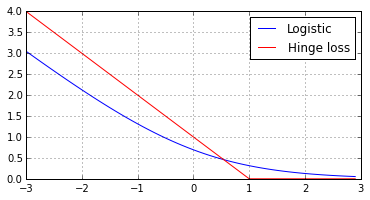

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def logit_loss(s):
    return np.log(1 + np.exp(-s))

def hinge_loss(s):
    return np.maximum(0, 1-s)

s = np.arange(-3, 3, 0.1)

# plot the sigmoid curve.
plt.figure(figsize=(6, 3))
plt.plot(s, logit_loss(s), label="Logistic")
plt.plot(s, hinge_loss(s), color='r', label="Hinge loss")
plt.grid()
plt.legend()
plt.show()

## SVM by gradient descent

Given the loss function $\ell_(\beta) = \sum_{i=1}^{n} \max (0, 1 - y_i x_i^T \beta) + \dfrac{\lambda}{2}|\beta|^2$, we can solve $\beta$ by gradient descent.

Take derivative, we have

$$
\dfrac{\partial \ell}{\partial \beta} = \sum_{i=1}^{n} \mathbb{1}(1-y_i x_i^T \beta < 1)\cdot (-y_i x_i) + \lambda \beta,
$$
where $\mathbb{1}(\cdot)$ is an indicator function.

The code from logistic regression can be reused with a minor change in the gradient calculation.

In [2]:
np.random.seed(1)

def svm(x, y, x_test, y_test, num_iteration=1000, learning_rate=1e-2, regularization=0.1):
    r, c = x.shape

    p = c + 1
    X = np.hstack((np.ones((r,1)), x))
    beta = 2*np.random.randn(p, 1)-1
    
    X_test = np.hstack((np.ones((x_test.shape[0],1)), x_test))
    acc, acc_test = [], []
    
    for i in xrange(num_iteration):
        score = X.dot(beta)
        db = (score * y) < 1
        dbeta = X.T.dot(db*y) / r;
        beta = beta + learning_rate *dbeta - regularization*beta; 
        
        # accuracy on training and testing data
        acc.append(np.mean(np.sign(score) == y))
        acc_test.append(np.mean(np.sign(X_test.dot(beta)) == y_test))
    
    return beta, acc, acc_test


# training: 255
# testing : 110


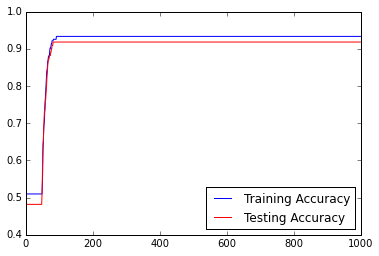

In [3]:
from common import load_digits, split_samples

# Load digits and split the data into two sets.
digits, labels = load_digits(subset=[3, 5], normalize=True)
training_digits, training_labels, testing_digits, testing_labels = split_samples(digits, labels)

print '# training:', training_digits.shape[0]
print '# testing :', testing_digits.shape[0]

# Transform labels from {0, 1} to {-1, 1}.
training_labels = 2* training_labels -1
testing_labels = 2* testing_labels -1

# Train a svm classifier.
beta, acc, acc_test = svm(training_digits, training_labels, testing_digits, testing_labels)

# Plot the accuracy.
plt.figure()
plt.plot(range(len(acc)), acc, color='b', label='Training Accuracy')
plt.plot(range(len(acc)), acc_test, color='r', label='Testing Accuracy')
plt.legend(loc='best')
plt.show()

## Dual form

Historically, people transfrom the primal form to a dual form. The idea is to view the problem from the geometry perspective.

<img src="figures/svm-dual.pdf">

Consider the convex hull of the positive and negative population, the margin between the two population is therefore defined by the minimum distance betweent two. Let $x_{+} = \sum_{i\in +} c_i x_i$ and $x_{-} = \sum_{i\in -} c_i x_i$ ($c_i \geq 0, \sum_{i\in +} c_i = 1, \sum_{i\in -} c_i = 1$) be two points in the positive and negative population (in the region of the convex hull). The margin is 
$$\min \left|x_{+} - x_{-}\right|^2.$$

It can be rewriten as 
$$
\begin{align}
\left|x_{+} - x_{-}\right|^2 &= \left| \sum_{i\in +} c_i x_i - \sum_{i\in -} c_i x_i \right|^2 \\  
&= \left| \sum_{i} y_i c_i x_i \right |^2 \\  
&= \sum_{i,j} c_i, c_j y_i y_j \langle x_i , x_j \rangle, \\
\textrm{subject to} \quad & c_i \geq 0, \sum_{i\in +} c_i = 1, \sum_{i\in -} c_i = 1.
\end{align}
$$

After we solve for $c$, non-zeros $c_i$'s are support vectors, i.e. data examples on the boundary.